In [2]:
import bq
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

In [3]:
client = bq.Client.Get()

def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [4]:
q = '''SELECT
  timestamp,
  lat, 
  lon,
  IF( REGEXP_REPLACE(tagblock_station, 'u', '') IN ('rORBCOMM000',
  'rORBCOMM00',
        'rORBCOMM001',
        'rORBCOMM008',
        'rORBCOMM009',
        'rORBCOMM010'),'terrestrial', 'satellite') receiver,
FROM
  TABLE_DATE_RANGE([pipeline_740__classify_hours.],TIMESTAMP("2015-03-10"), TIMESTAMP("2015-03-31"))
WHERE
  mmsi = 413270430
  AND lat<90
  AND lon<180
  AND lat>-90
  AND lon>-180
order by timestamp'''

vessel = Query(q)

Waiting on bqjob_r4be62c7b5a8da3ef_00000157fe95697c_1 ... (0s) Current status: DONE   
Query time: 3.11387300491 seconds.


In [5]:
lats_terr = np.array([float(v[1]) for v in vessel if v[3]=="terrestrial"])
lons_terr = np.array([float(v[2]) for v in vessel if v[3]=="terrestrial"])
lats = np.array([float(v[1]) for v in vessel if v[3]!="terrestrial"])
lons = np.array([float(v[2]) for v in vessel if v[3]!="terrestrial"])
for i in range(len(lons)): # adjust for the dateline
    if lons[i]<0: lons[i]+=360
max_lat = lats.max()
min_lat = lats.min()
max_lon = lons.max()
min_lon = lons.min()

In [6]:
# figure out what the bounds should be
print min_lat, max_lat
print min_lon, max_lon

6.9406199455 35.0449981689
123.466667175 182.698516846


In [7]:
# adjust the bounds out a bit to get more of Japan and China
min_lat = -5
max_lat = 50
max_lon = 180
min_lon = 110

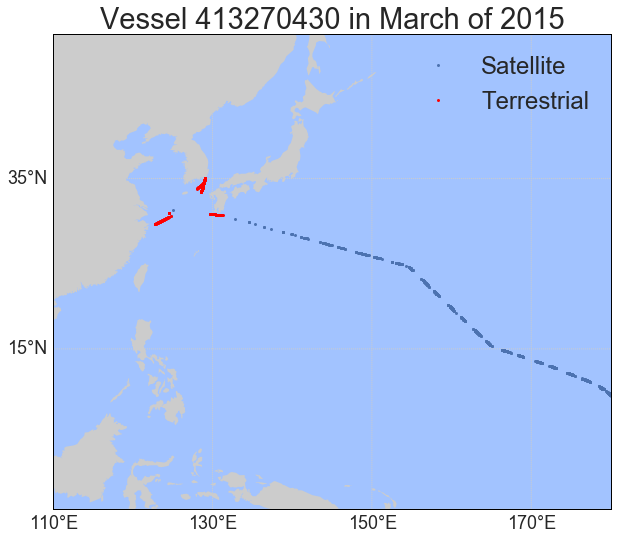

In [8]:
sns.set_style("white")
plt.figure(figsize=(10,10)) 

m = Basemap(llcrnrlon=min_lon,llcrnrlat=min_lat,
            urcrnrlon=max_lon,urcrnrlat=max_lat,projection='mill', resolution ='l')

m.drawmapboundary()
m.fillcontinents("#cccccc",lake_color="#cccccc")
parallels = np.arange(min_lat,max_lat,20.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=18,color='#cccccc')
meridians = np.arange(min_lon,max_lon,20.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=18,color='#cccccc')

m.drawmapboundary(fill_color='#A2C3FF')

x,y= m(lons,lats)
size = 3
m.plot(x,y,marker = 'o',markersize=size,markeredgecolor = 'none',
       alpha = 1,linestyle='None', label="Satellite")
x,y= m(lons_terr,lats_terr)
size = 3
m.plot(x,y,marker = 'o',markersize=size,markeredgecolor = 'none',
       alpha = 1,linestyle='None', label="Terrestrial", color = "red")


plt.title("Vessel 413270430 in March of 2015", 
         fontsize=29)
plt.legend(fontsize=24)
plt.show()

In [9]:
q = '''SELECT
  DAY(timestamp) day,
  HOUR(timestamp) hour,
  IF( REGEXP_REPLACE(tagblock_station, 'u', '') IN ('rORBCOMM000',
  'rORBCOMM00',
        'rORBCOMM001',
        'rORBCOMM008',
        'rORBCOMM009',
        'rORBCOMM010'),'terrestrial', 'satellite') receiver,
  COUNT(*) pings
FROM
  TABLE_DATE_RANGE([pipeline_740__classify_hours.],TIMESTAMP("2015-03-10"), TIMESTAMP("2015-03-31"))
WHERE
  mmsi = 413270430
  AND lat<90
  AND lon<180
  AND lat>-90
  AND lon>-180
GROUP BY
  day, hour,receiver
ORDER BY
  day, hour'''

vessel = Query(q)

Waiting on bqjob_r538d0b2dc3de4abb_00000157fe95794e_2 ... (0s) Current status: DONE   
Query time: 1.63332891464 seconds.


In [10]:
datetimes = [datetime(2015,3,10)+timedelta(seconds=i*3600) for i in range(21*24)]
values = [np.zeros(2) for i in range(21*24)]
df = pd.DataFrame(data=values, index=datetimes,columns=['satellite','terrestrial'])

In [11]:
for v in vessel:
    df.ix[datetime(2015,3,int(v[0]),int(v[1]))][v[2]] = int(v[3])

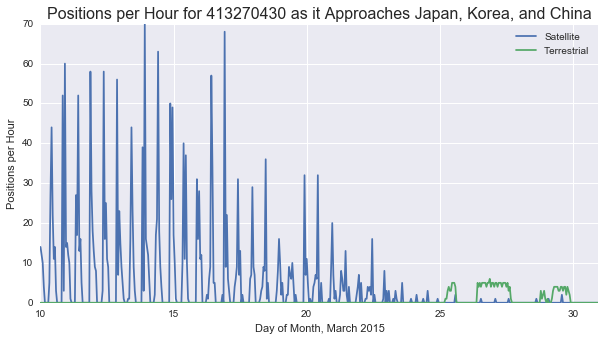

In [13]:
formatter = DateFormatter('%d')

sns.set_style("darkgrid")
sns.despine()
plt.figure(figsize=(10,5)) 
plt.plot(df.index,df['satellite'],label="Satellite")
plt.plot(df.index,df['terrestrial'],label="Terrestrial")
plt.title("Positions per Hour for 413270430 as it Approaches Japan, Korea, and China", 
         fontsize=16)
plt.ylabel("Positions per Hour")
plt.xlabel("Day of Month, March 2015")
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.xticks([df.index[i*24] for i in range(0,len(df.index)/24,5)])

plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.legend()
plt.savefig("pos_per_hour.png", dpi=500)
plt.show()

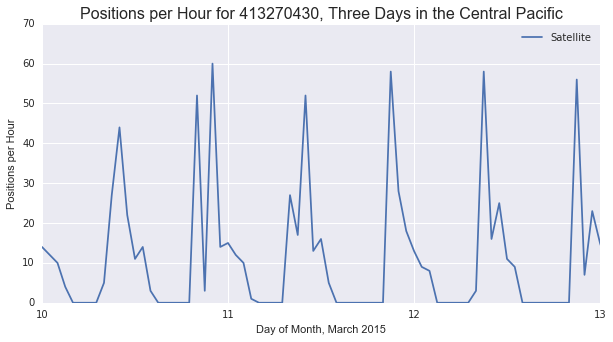

In [218]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df.index,df['satellite'],label="Satellite")
# plt.plot(df.index,df['terrestrial'],label="Terrestrial")
plt.title("Positions per Hour for 413270430, Three Days in the Central Pacific", 
         fontsize=16)
plt.ylabel("Positions per Hour")
plt.xlabel("Day of Month, March 2015")
# plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

# plt.xlim(0,10)
ax.set_xlim(df.index[0],df.index[3*24])
plt.xticks([df.index[i*24] for i in range(4)])

plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

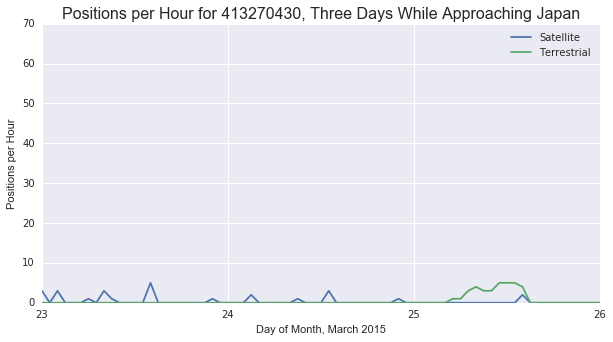

In [219]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df.index,df['satellite'],label="Satellite")
plt.plot(df.index,df['terrestrial'],label="Terrestrial")
plt.title("Positions per Hour for 413270430, Three Days While Approaching Japan", 
         fontsize=16)
plt.ylabel("Positions per Hour")
plt.xlabel("Day of Month, March 2015")
# plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

# plt.xlim(0,10)
ax.set_xlim(df.index[13*24],df.index[13*24+3*24])
plt.xticks([df.index[i*24+13*24] for i in range(4)])

plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

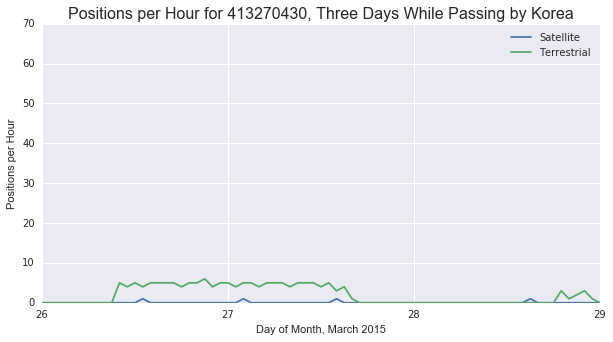

In [220]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df.index,df['satellite'],label="Satellite")
plt.plot(df.index,df['terrestrial'],label="Terrestrial")
plt.title("Positions per Hour for 413270430, Three Days While Passing by Korea", 
         fontsize=16)
plt.ylabel("Positions per Hour")
plt.xlabel("Day of Month, March 2015")
# plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

# plt.xlim(0,10)
ax.set_xlim(df.index[16*24],df.index[16*24+3*24])
plt.xticks([df.index[i*24+16*24] for i in range(4)])

plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()